In [1]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])

target_paths = sorted([os.path.join(target_dir, fname) 
                      for fname in os.listdir(target_dir) 
                      if fname.endswith(".png") and not fname.startswith(".")])

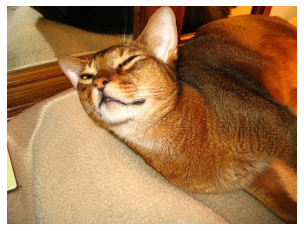

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[63]))

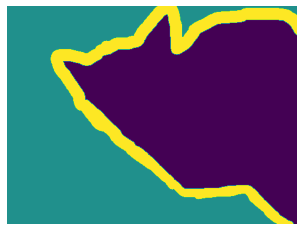

In [3]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[63], color_mode="grayscale"))
display_target(img)

In [4]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_images = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

2022-09-09 15:19:46.758793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

2022-09-09 15:19:47.153505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:19:47.154055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 15:19:47.157978: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-09 15:19:47.161800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]

history = model.fit(train_input_imgs, train_targets, epochs=50, callbacks=callbacks, batch_size=32, validation_data=(val_input_images, val_targets))
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

2022-09-09 15:19:49.991376: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3067200000 exceeds 10% of free system memory.
2022-09-09 15:19:51.516017: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3067200000 exceeds 10% of free system memory.


Epoch 1/50


2022-09-09 15:20:00.378343: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-09-09 15:20:05.824355: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-09-09 15:20:05.829549: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-09-09 15:20:05.829633: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-09-09 15:20:05.847661: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

 31/200 [===>..........................] - ETA: 13s - loss: 22.3775

KeyboardInterrupt: 

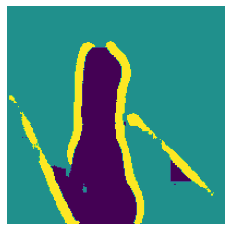

In [8]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_images[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

Modularity-Hierarchy-Reuse (MHR) is the idea of taking a complex system, structuring it into modules, placing these modules in a hierarchy, and resusing the same modules in places where appropriate. 

Deep learning models are a lot like chinese whispers, they are chained functions and noise can impact the overall output! If you have enough layers, this noise is overwhelming and you get the vanishing gradient problem! This prevents backpropagation from happening, and means your model wont train!. An easy way to deal with this is to provide a noiseless version of the information contained in the previous input, and the easiest way to do this is using residual connections! This was introduced with ResNet! This implies that the input dimensions are the same as the output, which is not the case if you use strided convolutions, or don't use padding!In these cases we can use a 1x1 Conv2D layer with no activation. 

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

# residual block where the number of filters changes
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

# case where the target block includes a max pooling layer
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPool2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual) #striding here is done to match the output dimensions after the max pooling
x = layers.add([x, residual])

With residual connections we can build networks of arbitrary depth, without having to worry about connections. 

In [10]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x 

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_1[0][0]']            
                                                                                                  
 conv2d_14 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_13[0][0]']              
                                                                                            

Batch normalisation makes samples more similiar to each other, which helps the model learn and generalise well to new data. 

In [11]:
normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)


NameError: name 'data' is not defined

We are used to seeing normalisation being applied to input data, but there is no reason to expect data to have mean 0 and unit variance after a layer. Apply batch normalisation after each intermediate activation layer helps, but no one really knows the reason why! During training the batch normalisation layer normalises samples using an exponential moving average of the batch-wise mean and variance of the data seen during training. Batch normalisation allows networks to much deeper than if it weren't used, and is often used liberally in very deep networks like ResNet. The batch normalisation layer can be used after any keras layer. 

In [ ]:
x = ...
x = layers.Conv2D(32, 3, use_bias=False)(x) # Because the output of the Conv2D layer gets normalised, the layer doesn't need its own bias vector! This makes the layer slightly leaner. 
x = layers.BatchNormalization()(x)

Recommended to do activation function after batch normalisation, this looks like below. This will center your inputs on zero, which is good for relu! That being said, if you do normalisation after the activation function we won't necessarily see worse results, this bit is still debated!

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

When fine tuning a network with batch normalisation layers, freeze those layers!!! Otherwise they will keep updating their internal mean and variance which can interfere with very small updates applied to the surrouding layers!

The depthwise seperable convolutional layer (SeperableConv2D) can be used as a drop-in replacement for the Conv2D layer, has fewer trainable weights and can make the model perform slightly better! This layer performs a spatial convolution on each channel of its input independantly, before mixing output channels via a pointwise convolution (a 1x1 convolution).

Let's put all this together is a mini Xception-like model! We will put into practise some of the convnet architecture principles we have learned:
- Model will be made of repeated blocks of conv and max pool layers. 
- Number of filters increases as size of spatial feature maps decreases.
- Deep and narrow is better than broad and shallow.
- Residual connections help train deeper networks. 
- Can be beneficial to add batch normalisation layers after conv layers. 
- Can be beneficial to replace Conv2D layers with SeperableConv2D layers.

In [15]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Lets apply it to the cat-vs-dogs dataset from chapter 8! We'll re-use some code here:

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Epoch 1/30


2022-09-09 15:39:41.233470: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 22s 304ms/step - loss: 0.7150 - accuracy: 0.5485 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 2/30
63/63 [==============================] - 18s 278ms/step - loss: 0.6671 - accuracy: 0.5975 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 17s 274ms/step - loss: 0.6501 - accuracy: 0.6230 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 17s 275ms/step - loss: 0.6282 - accuracy: 0.6510 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 5/30
63/63 [==============================] - 17s 272ms/step - loss: 0.6006 - accuracy: 0.6735 - val_loss: 0.7281 - val_accuracy: 0.5000
Epoch 6/30
63/63 [==============================] - 17s 272ms/step - loss: 0.5912 - accuracy: 0.6875 - val_loss: 0.7805 - val_accuracy: 0.5000
Epoch 7/30
63/63 [==============================] - 17s 275ms/step - loss: 0.5672 - accuracy: 0.7170 - val_loss: 1.0203 - val_accuracy: 0.5000
Epoch 8/30

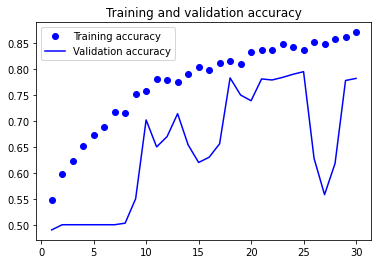

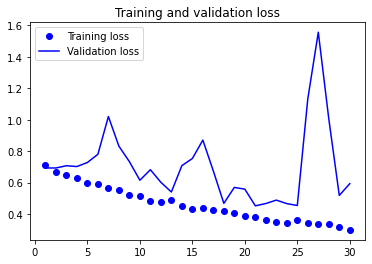

In [16]:
from tensorflow.keras.utils import image_dataset_from_directory
import os, shutil, pathlib

original_dir = pathlib.Path("dogs-vs-cats/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

callbacks = [keras.callbacks.ModelCheckpoint(filepath="XCeption_like_model.keras",
                                             save_best_only=True, monitor="val_loss")]
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

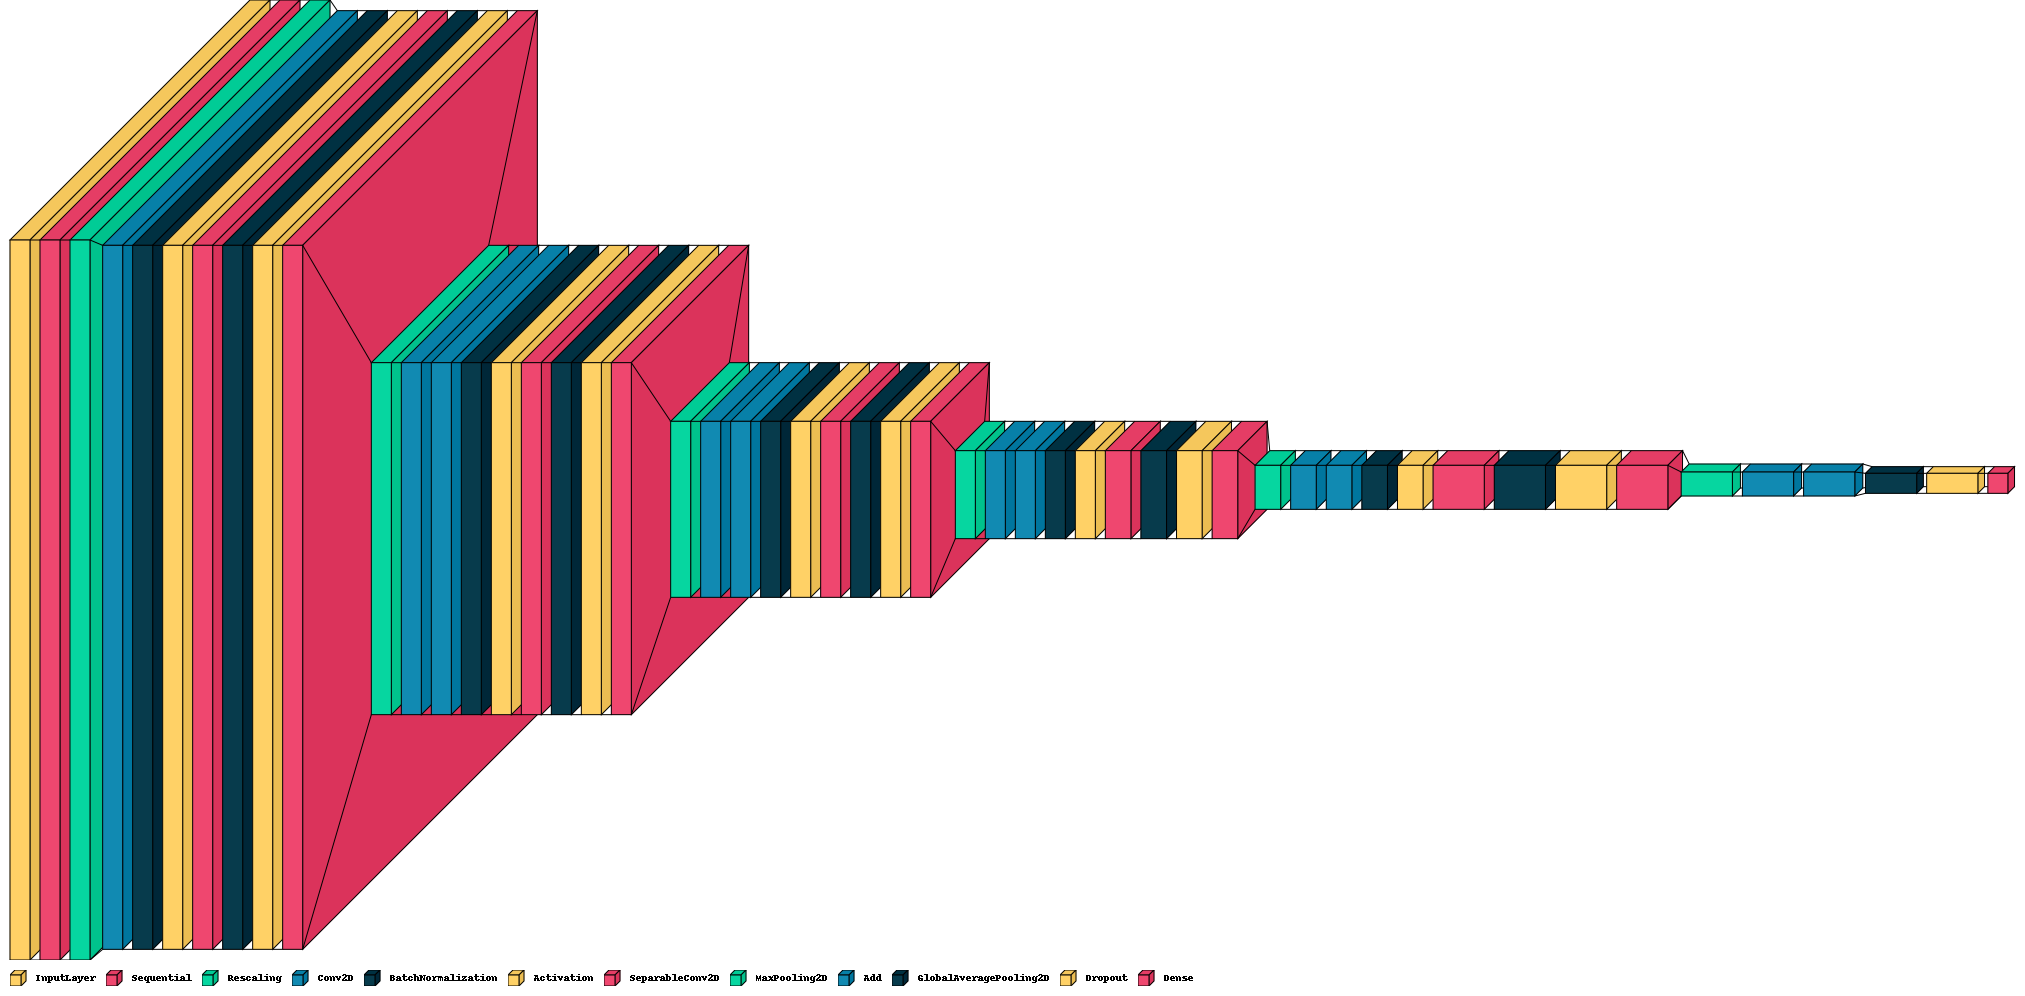

In [21]:
# from tensorflow.keras.utils import plot_model

# plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False,
# )

import visualkeras
from PIL import ImageFont

visualkeras.layered_view(model, legend=True)


Interpretability is import for computer vision applications, in particular when they are used to compliment a human expert. We will cover three techniques for interpreting what convnets learn:
- Visualising intermediate convnet outputs (intermediate activations)
- Visualising convnet filters
- Visualising heatmaps of class activations in an image

Starting with intermediate activations:

In [2]:
from tensorflow import keras
import numpy as np

model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")

img_path = keras.utils.get_file(fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img= keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

2022-09-09 16:55:58.338460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:55:58.582723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:55:58.583260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:55:58.587351: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

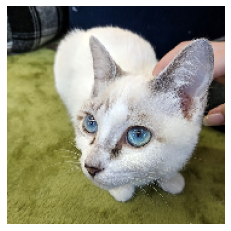

In [3]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [4]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt

layer_outputs = []
layer_names = []

for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPool2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) #Returns all layers as outputs!

activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]

# This is a (1, 178, 178, 32) feature map, lets plot the 5th channel!

2022-09-09 16:56:07.962511: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-09-09 16:56:14.610059: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-09-09 16:56:14.615243: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-09-09 16:56:14.615325: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-09-09 16:56:14.617521: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

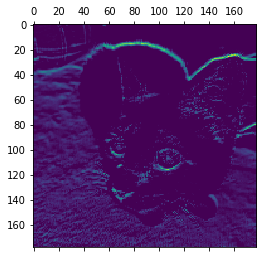

In [5]:
plt.matshow(first_layer_activation[0, :, :, 31], cmap="viridis")

Lets plot a complete visualisation of all the activations in the network!

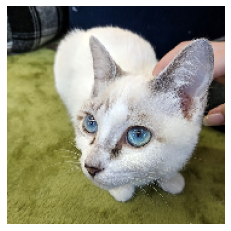

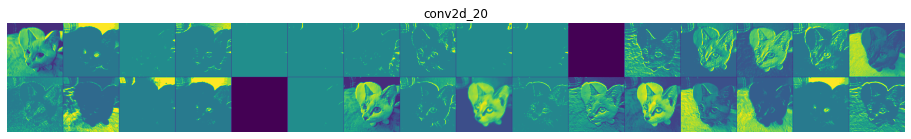

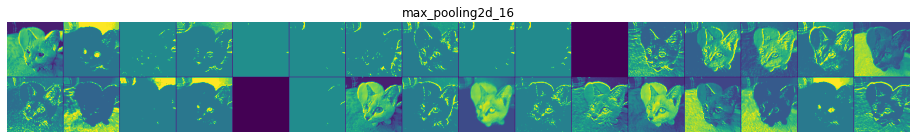

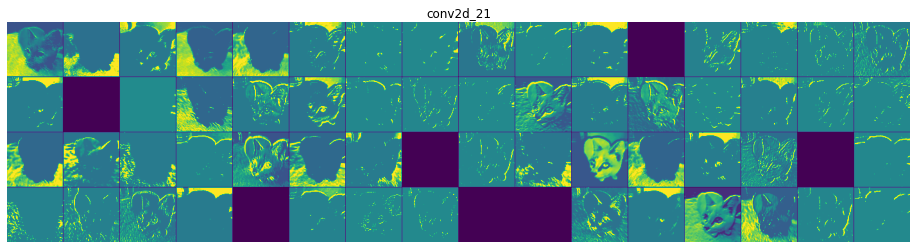

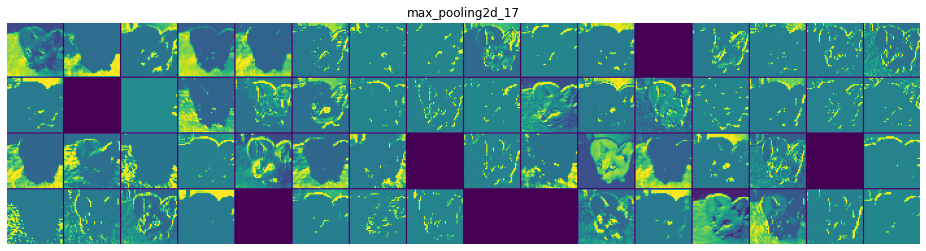

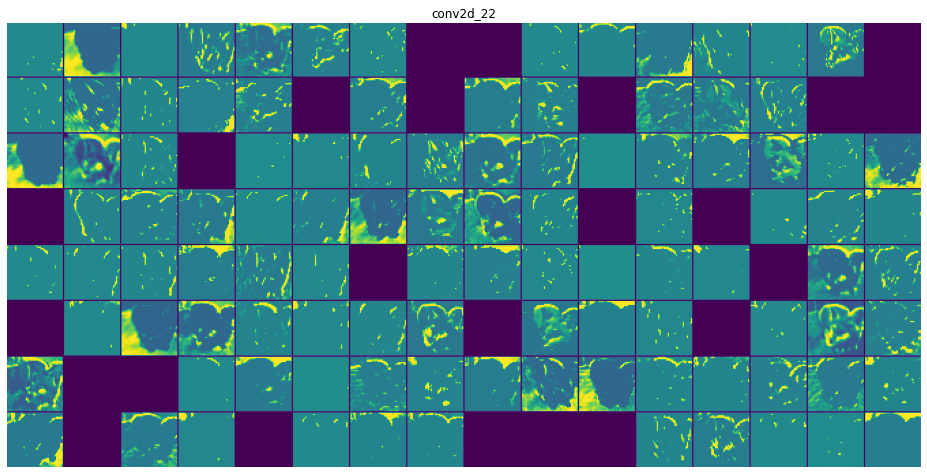

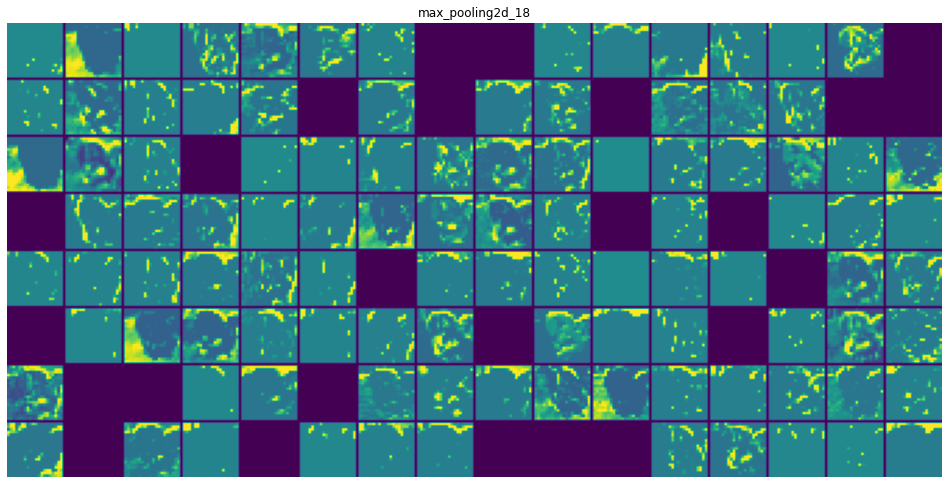

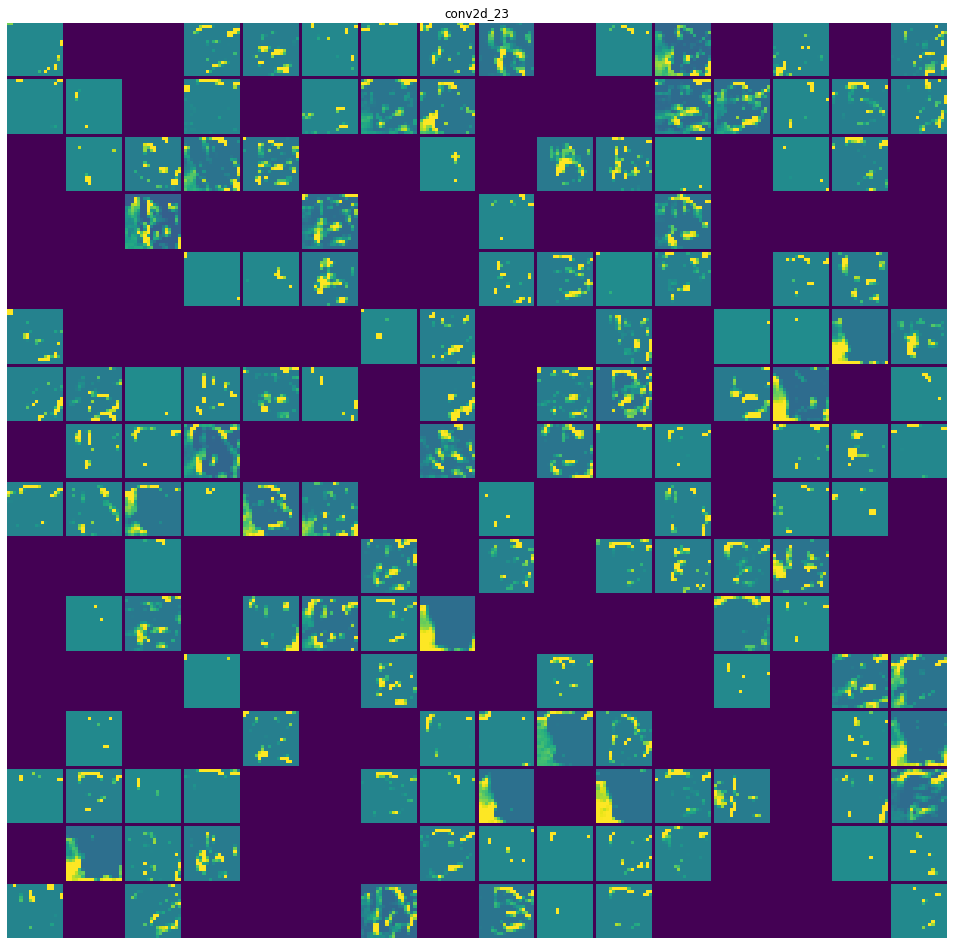

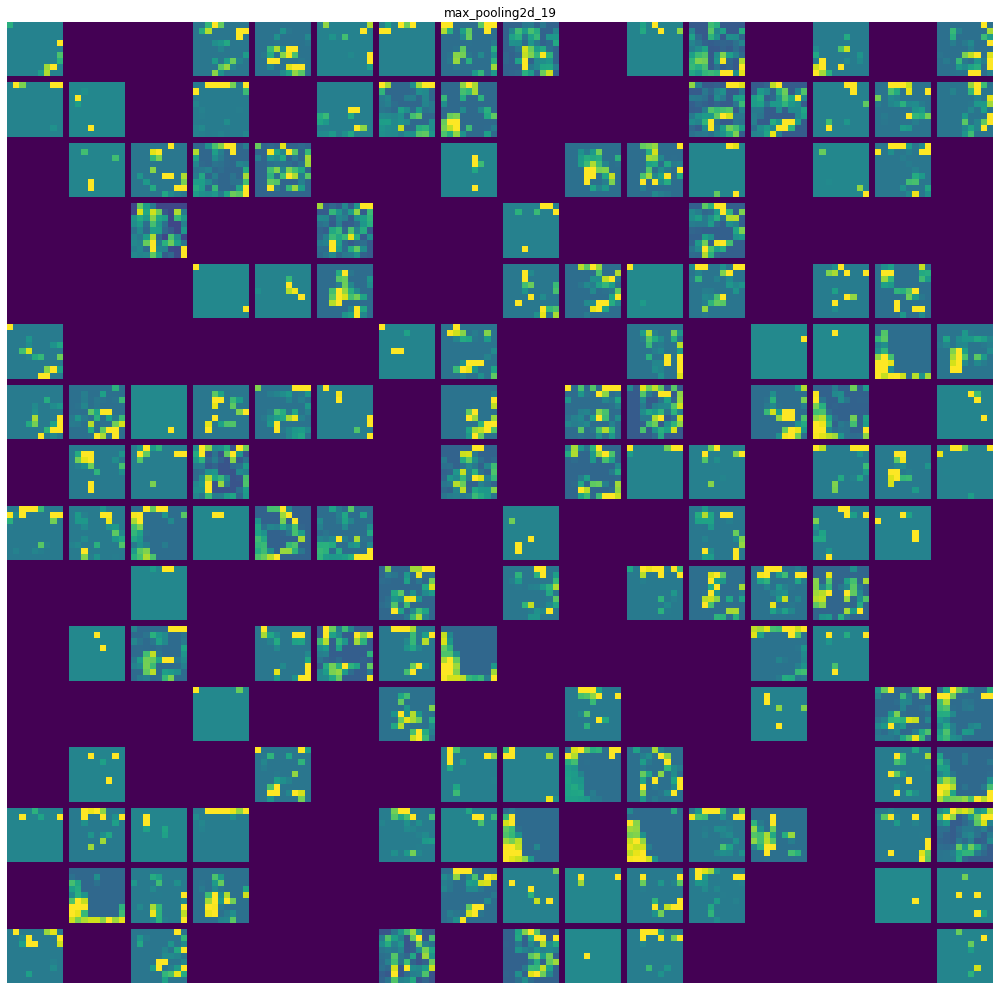

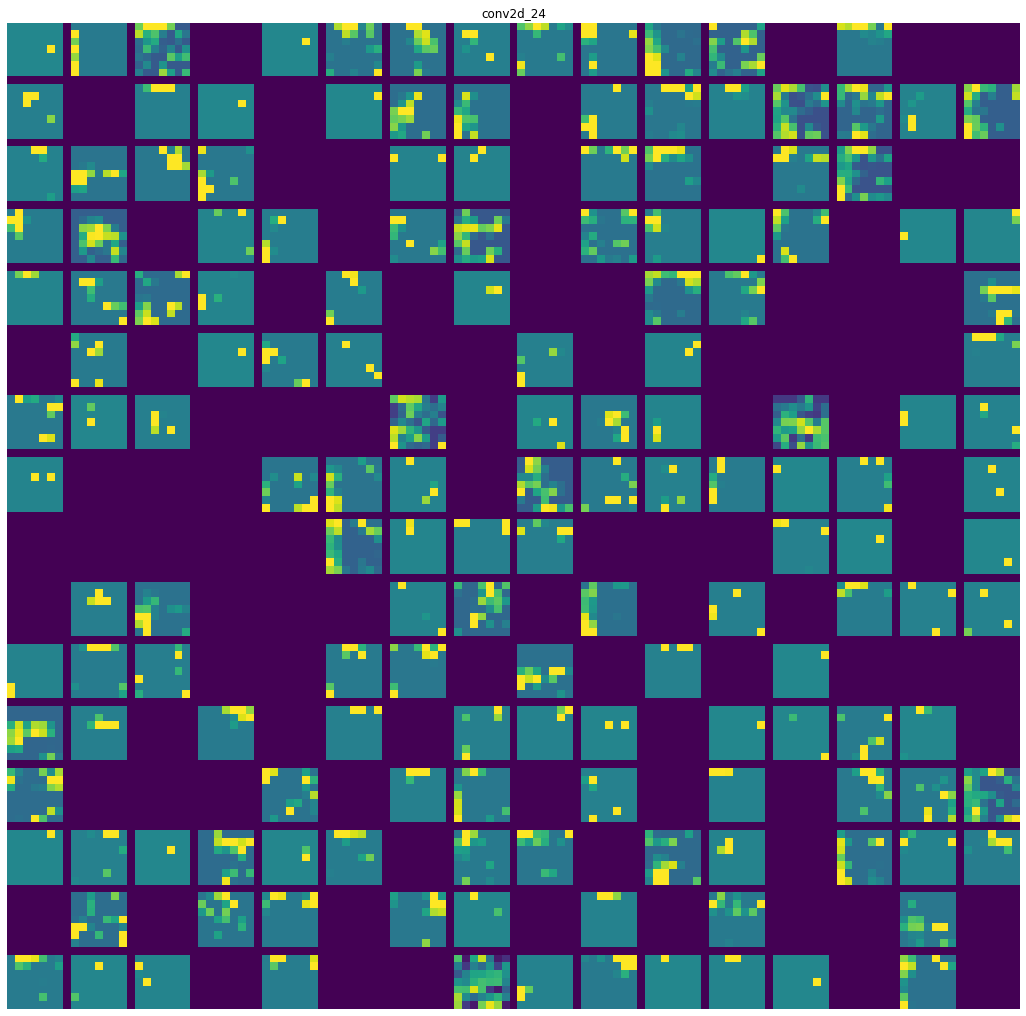

In [9]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = (col * images_per_row) + row
            channel_image = layer_activation[0, :, :, channel_index].copy()

        # Normalise channel values within [0,255] range
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[col * (size + 1): (col + 1) * size + col, row * (size + 1) : (row + 1) * size + row] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")


The first layer acts a collection of various edge detectors! AS we go deeper, activations represent increasingly abstract things. The sparsity of activations also increases with depth! 

We can also inspect the filters learned by a convnet with gradient ascent! Apply gradient descent as to increase the response of a specfic filter! To do this we need to build a loss function that maximises the value of a given filter in a given convolution layer. 

In [10]:
model = keras.applications.xception.Xception(weights="imagenet", include_top=False)

for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

83697664/83683744 [==============================] - 9s 0us/step
block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [19]:
layer_name = "block4_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output) # This creates a model that given an input image returns the output of our target layer!

activation = feature_extractor(
keras.applications.xception.preprocess_input(img_tensor)
)

Lets use the feature extractor to define a function that returns a scalar value quantifying how much a given image activations a given filter! This is the loss function we will maximise during the gradient ascent process. 

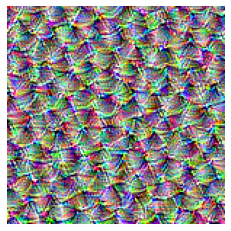

In [20]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image) # We don't use .predict() here because we can't retrieve gradients using that methods!
    filter_activation = activation[:, 2:-2, 2:-2, filter_index] # To ingore border effects we discard two pixels along the sides of the activation
    return tf.reduce_mean(filter_activation) # return the mean of the activation values

@tf.function
def gradient_accent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grad = tf.math.l2_normalize(grads) # Apply the "gradient normalisation trick"ArithmeticError
    image += learning_rate * grads
    return image

img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_accent_step(image, filter_index, learning_rate)
    return image[0].numpy()

def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

We can do this for every filter in the model!

In [21]:

all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
    generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        row_start = (cropped_width + margin) * i
        row_end = (cropped_width + margin) * i + cropped_width
        column_start = (cropped_height + margin) * j
        column_end = (cropped_height + margin) * j + cropped_height
        stitched_filters[
        row_start: row_end,
        column_start: column_end, :] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

Visualising heatmaps of class activations. Useful for "debugging" the decision process of a convnet. This general category of techniques is called class activation maps (CAM) visualisation.  We will use Grad-CAM! 

In [24]:
model = keras.applications.xception.Xception(weights="imagenet")

img_path = keras.utils.get_file(fname="elephant.jpg", origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299,299))

preds = model.predict(img_array)

print(keras.applications.xception.decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0]))

[('n02504458', 'African_elephant', 0.86986876), ('n01871265', 'tusker', 0.0769916), ('n02504013', 'Indian_elephant', 0.02357965)]
386


First we create a model that maps the input image to the activations of the last convolutional layer. Then create a model that maps the activations of the last conv layer to the final class predictions. Then we compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer. 

In [25]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
"avg_pool",
"predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output) # This is a model that when given an image will return the output of the last conv layer

classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

Now we apply pooling and imprtance weighting to the gradient tensor to obtain the heatmap

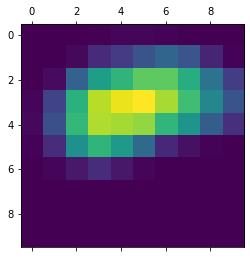

In [26]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # This is a vector where each entry is the mean intensity of the gradient for a given channel. 
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i] # Here we multiply each channel output in the output of the last conv layer by "how imprtant it is"
heatmap = np.mean(last_conv_layer_output, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [27]:
import matplotlib.cm as cm
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)